## 1. Descripción del dataset

El objeto de estudio es un *dataset* que abarca las reservas de dos hoteles distintos, un hotel de tipo resort y otro urbano, desde el año 2015 hasta el 2017. 

La importancia del estudio reside en la identificación de las características de una reserva que tiene impacto en el precio medio de las habitaciones y cómo podemos optimizar este, ya sea alargando o reduciendo la estancia, por ejemplo. Es decir, el objetivo es determinar las variables que impactan en el $ adr $ (del inglés, Average Daily Room "€"). Las variables estudiadas son:

- **hotel:** Hotel (H1 = Resort Hotel or H2 = City Hotel)
- **lead_time:** Number of days that elapsed between the entering date of the booking into the PMS and the arrival date
- **arrival_date_year:** Year of arrival date
- **arrival_date_month:** Month of arrival date
- **arrival_date_week_number:** Week number of year for arrival date
- **stays_in_weekend_nights:** Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- **stays_in_week_nights:** Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
- **country:** Country of origin. Categories are represented in the ISO 3155–3:2013 format
- **market_segment:** Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”
- **reserved_room_type:** tipo de habitacion ('A', 'B', 'C'...)
- **adr:** Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights

# 2. Integración y selección de los datos

In [53]:
import numpy as np
import pandas as pd
import statistics
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import requests
import sklearn
from bs4 import BeautifulSoup as BS
from sklearn import datasets, linear_model, metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

Cargamos el *dataset* y comprobamos su tamaño:

In [2]:
data = pd.read_csv('hotel_bookings.csv')

# Comprobamos sus dimensiones
data.shape

(119390, 32)

Mantenemos únicamente las variables que nos interesan:

In [3]:
# Mantenemos únicamente las variables que nos interesan
variables = [
    "hotel", "lead_time",
    "arrival_date_year", "arrival_date_month", "arrival_date_week_number",
    "stays_in_weekend_nights", "stays_in_week_nights",
    "country", "market_segment",
    "adr","reserved_room_type"
]

data = data[variables]

In [4]:
# Comprobamos sus dimensiones
data.shape

(119390, 11)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   hotel                     119390 non-null  object 
 1   lead_time                 119390 non-null  int64  
 2   arrival_date_year         119390 non-null  int64  
 3   arrival_date_month        119390 non-null  object 
 4   arrival_date_week_number  119390 non-null  int64  
 5   stays_in_weekend_nights   119390 non-null  int64  
 6   stays_in_week_nights      119390 non-null  int64  
 7   country                   118902 non-null  object 
 8   market_segment            119390 non-null  object 
 9   adr                       119390 non-null  float64
 10  reserved_room_type        119390 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 10.0+ MB


A simple vista, parece ser que los datos están en el formato esperado. Contamos con cuatro variables categóricas:

- **hotel:** tipo de hotel ('Resort Hotel' o 'City Hotel')
- **arrival_date_month:** mes de llegada ('January', 'February'...)
- **country:** país de origen representado en el formato ISO 3155–3:2013 ('ESP', 'USA'...)
- **market_segment:** segmento de mercado ('Direct', 'Corporate' 'Online TA'...)
- **reserved_room_type:** tipo de habitacion ('A', 'B', 'C'...)

y seis variables numéricas:

- **lead_time:** días de antelación para la reserva
- **arrival_date_year:** año de llegada
- **arrival_date_week_number:** semana del año de llegada
- **stays_in_weekend_nights:** noches del fin de semana (Sábado o Domingo) reservadas 
- **stays_in_week_nights:** noches de la semana (Lunes a Viernes) reservadas
- **adr:** precio medio de la noche, dividiendo el precio total por el número de noches reservadas

en total, diez variables.

# 3. Limpieza de los datos

A continuación, procedemos a preparar el conjunto de datos para su posterior análisis. Para ello, se examinarán los datos para detectar y corregir posibles errores, inconsistencias y valores perdidos.

La preparación de los datos cada vez cobra más importancia, dado que la base de cualquier estudio estadístico es la información recogida, es decir, los datos disponibles para realizar el modelo y obtener las conclusiones.

Comprobamos la existencia de valores nulos en el conjunto de datos:

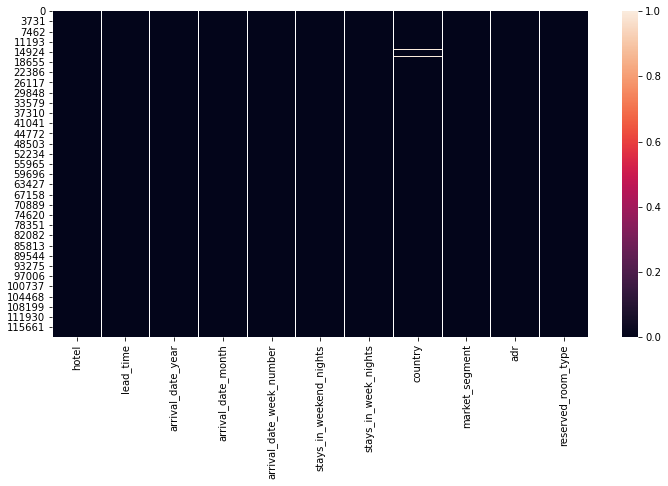

In [6]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull());

Observamos que algunas reservas no tienen informadas el país de origen, pero, como su número es insignificante, las eliminamos del conjunto de datos:

In [7]:
data = data.dropna()

## 3.1. Preprocesado de variables categóricas

La comprobación que hemos hecho no es suficiente para garantizar la ausencia de valores desconocidos. Estudiemos variable por variable en búsqueda de anomalías que nos sugieran que su valor es desconocido:

### **hotel**

In [8]:
list(data["hotel"].unique())

['Resort Hotel', 'City Hotel']

### **arrival_date_month**

In [9]:
sorted(data["arrival_date_month"].unique(), key = lambda m: datetime.strptime(m, "%B"))

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

### **country**

In [10]:
countries = set(data["country"].unique())
list(data["country"].unique()[0:5])

['PRT', 'GBR', 'USA', 'ESP', 'IRL']

In [11]:
len(data["country"].unique())

177

El conjunto de datos contiene reservas de 177 países. A continuación, vamos a comprobar que todos estos están en **formato ISO 3166-1 alpha-3**, como indica el autor del *dataset*. Para ello, obtenemos la lista de Wikipedia:

In [12]:
headers = {
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,\
    */*;q=0.8",
    "Accept-Encoding": "gzip, deflate, sdch, br",
    "Accept-Language": "en-US,en;q=0.8",
    "Cache-Control": "no-cache",
    "dnt": "1",
    "Pragma": "no-cache",
    "Upgrade-Insecure-Requests": "1",
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3) AppleWebKit/5\
    37.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36"
}

url = "https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes"

response = requests.get(url, stream=True, headers=headers)

soup = BS(response.content, 'html.parser')

fields = soup.select('a[title="ISO 3166-1 alpha-3"] span')

ISO = set()

for field in fields:
    code = field.text
    ISO.add(code)

Comprobamos que todos los códigos están contenidos en la lista que obtuvimos de Wikipedia:

In [13]:
(set(ISO) & set(countries)) == set(countries)

False

In [14]:
countries - ISO

{'CN', 'TMP'}

Por un lado, 'CN' hace referencia a China, pero está en el formato ISO 3166-1 alpha-2, por lo que lo transformamos a su equivalente, 'CHN', en formato alpha-3:

In [15]:
data.loc[data["country"] == "CN", "country"] = "CHN"

Por otro, desconocemos el país al que hace referencia 'TMP', por lo que procedemos a su eliminación del conjunto de datos, no sin antes comprobar que solo un % pequeño de observaciones hacen referencia a él:

In [16]:
(data.loc[data["country"] == "TMP", "country"].count()/len(data))*100

0.0025230862390876524

In [17]:
data = data.drop(data.loc[data["country"] == "TMP", "country"].index)

### **market_segment**

In [18]:
list(data["market_segment"].unique())

['Direct',
 'Corporate',
 'Online TA',
 'Offline TA/TO',
 'Complementary',
 'Groups',
 'Undefined',
 'Aviation']

La variable *market_segment* tampoco se libra de los valores nulos. Comprobamos que son una parte pequeña del conjunto de datos y los eliminamos:

In [19]:
(data.loc[data["market_segment"] == "Undefined", "market_segment"].count()/len(data))*100

0.0016820999335570527

In [20]:
data = data.drop(data.loc[data["market_segment"] == "Undefined", "market_segment"].index)

### **reserved_room_type**

In [21]:
data["reserved_room_type"].value_counts()

A    85600
D    19172
E     6497
F     2889
G     2083
B     1116
C      931
H      601
L        6
P        2
Name: reserved_room_type, dtype: int64

## 3.2. Preprocesado de variables numéricas

### **lead_time**

In [22]:
pd.DataFrame(data["lead_time"].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
lead_time,118897.0,104.311101,106.904193,0.0,18.0,69.0,161.0,737.0


Parece raro que una reserva se haga con 737 días de antelación. Vamos a representar los valores en una caja de bigotes para identificar valores extremos:

/Users/mohammed/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


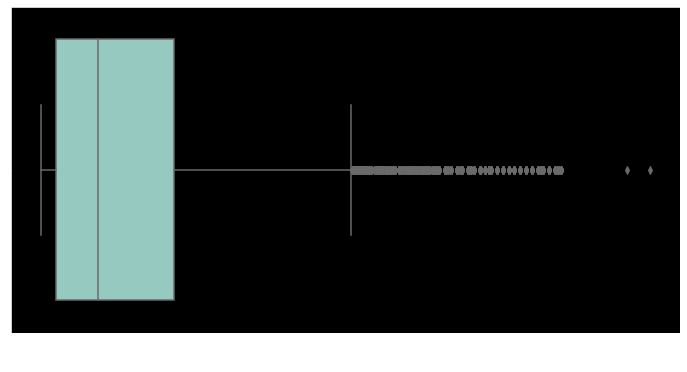

In [23]:
plt.figure(figsize=(12, 6))
plt.style.use('dark_background')

sns.boxplot(data['lead_time'])

plt.show()

Establecemos que aquellos valores que sean mayores que 1.5 veces el valor del rango intercuartil (IQR) son anómalos.

In [24]:
# ¿Cuál es el rango intercuartil de 'lead_time'?
Q1, Q3 = data['lead_time'].quantile([.25, .75])
# Rango intercuartil = Tercer cuartil - Primer cuartil
IQR = Q3 - Q1 
IQR

143.0

In [25]:
# ¿Cuántos valores anómalos tiene la variable 'lead_time'?
((data['lead_time'] < (Q1 - 1.5 * IQR)) | (data['lead_time'] > (Q3 + 1.5 * IQR))).sum()

2982

In [26]:
# ¿Cuál es el % de estos comparado con el total?
((data['lead_time'] < (Q1 - 1.5 * IQR)) | (data['lead_time'] > (Q3 + 1.5 * IQR))).sum()*100/len(data)

2.5080531888945896

### **arrival_date_year**

In [27]:
list(data["arrival_date_year"].unique())

[2015, 2016, 2017]

### **arrival_date_week_number**

In [28]:
pd.DataFrame(data["arrival_date_week_number"].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
arrival_date_week_number,118897.0,27.166262,13.589722,1.0,16.0,28.0,38.0,53.0


In [29]:
len(data["arrival_date_week_number"].unique())

53

La muestra de reservas obtenida cubre todas las semanas del año.

In [30]:
data.dtypes["arrival_date_week_number"]

dtype('int64')

Los valores de la variable está contenida en el rango [1, 53] de los números naturales, como acabamos de comprobar.

### **stays_in_weekend_nights**

In [31]:
pd.DataFrame(data["stays_in_weekend_nights"].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
stays_in_weekend_nights,118897.0,0.928888,0.996224,0.0,0.0,1.0,2.0,16.0


### **stays_in_week_nights**

In [32]:
pd.DataFrame(data["stays_in_week_nights"].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
stays_in_week_nights,118897.0,2.502183,1.90018,0.0,1.0,2.0,3.0,41.0


Derivamos una columna que haga referencia a la estancia total:

In [58]:
data["total_stay"] = data["stays_in_week_nights"] + data["stays_in_weekend_nights"]
data.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,country,market_segment,adr,reserved_room_type,total_stay
0,Resort Hotel,342,2015,July,27,0,0,PRT,Direct,0.0,C,0
1,Resort Hotel,737,2015,July,27,0,0,PRT,Direct,0.0,C,0
2,Resort Hotel,7,2015,July,27,0,1,GBR,Direct,75.0,A,1
3,Resort Hotel,13,2015,July,27,0,1,GBR,Corporate,75.0,A,1
4,Resort Hotel,14,2015,July,27,0,2,GBR,Online TA,98.0,A,2


Nos aseguramos que la estancia total no sume cero:

In [34]:
len(data[data["total_stay"] == 0].index)

701

Aquellos registros cuya estancia total sume cero los tratamos sustituyendo el valor por la media:

In [35]:
data['total_stay'] = data['total_stay'].replace(0,int(data['total_stay'].mean()))
data.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,country,market_segment,adr,reserved_room_type,total_stay
0,Resort Hotel,342,2015,July,27,0,0,PRT,Direct,0.0,C,3
1,Resort Hotel,737,2015,July,27,0,0,PRT,Direct,0.0,C,3
2,Resort Hotel,7,2015,July,27,0,1,GBR,Direct,75.0,A,1
3,Resort Hotel,13,2015,July,27,0,1,GBR,Corporate,75.0,A,1
4,Resort Hotel,14,2015,July,27,0,2,GBR,Online TA,98.0,A,2


/Users/mohammed/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='total_stay'>

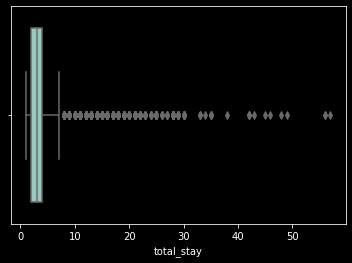

In [36]:
sns.boxplot(data['total_stay'])

Y tratamos los *outliers* eliminándolos:

In [37]:
data = data[data['total_stay'] < 10]

### **adr**

In [38]:
pd.DataFrame(data["adr"].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
adr,115656.0,102.050373,50.389811,0.0,70.0,95.0,126.0,5400.0


/Users/mohammed/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='adr'>

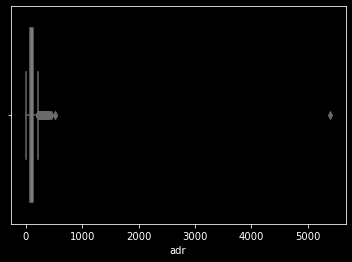

In [39]:
sns.boxplot(data['adr'])

Todo $ adr $ que esté por encima de 200 lo consideramos un valor anómalo y lo eliminamos del conjunto de datos.

In [40]:
data = data[data['adr'] < 200]

# 4. Análisis de los datos

## 4.1. Noches reservadas

Existe una opinión generalizada que el precio medio de la noche disminuye a medida que aumenta la estancia. Vamos a comprobar qué dicen los datos al respecto.

### Análisis visual

<AxesSubplot:xlabel='total_stay', ylabel='adr'>

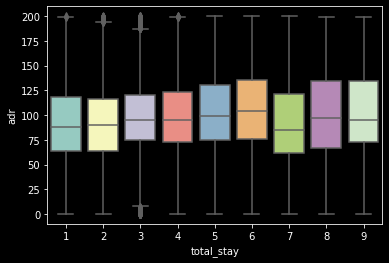

In [41]:
sns.boxplot(x = data['total_stay'] , y = data['adr'])

### Interpretación

Observamos que el precio medio de la noche es menor cuando se reservan 7 noches.

### Hipótesis nula y alternativa

Realizamos un contraste de hipótesis para comprobar si el precio medio reservando 7 días es menor que reservando cualquier otro número de días:

Proponemos que la hipótesis nula expresada en términos del parámetro $ \mu $ sea esta:

$ H_0: \mu_1 = \mu_2 $

$ H_1: \mu_1 - \mu_2 > 0 $

Siendo $ \mu_1 $ el precio medio reservando 7 días, y $ \mu_2 $ el precio medio reservando cualquier otro número de días.

### Tipo de test

Aplicaremos un contraste de hipótesis sobre diferencias de medias poblacionales. Respecto a la hipótesis alternativa, nos interesa que sea unilateral.

Antes de proceder al cálculo, comprobamos la normalidad de la variable:

In [42]:
k2, p = stats.normaltest(data["adr"])

In [43]:
alpha = 0.05

print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("Rechazamos hipótesis nula")
else:
    print("Aceptamos hipótesis nula")

p = 8.58519e-249
Rechazamos hipótesis nula


La variable no es normal, pero el tamaño de la muestra es superior a treinta observaciones, entonces, por el teorema del límite central, tenemos que la variable está distribuida $ N(0,1) $. 

### Cálculos

1. Determinamos el nivel de significación: $ \alpha = 0.05 $

In [44]:
alpha = 0.05

2. Calculamos:

    a) Las medias

In [45]:
n_7 = data.groupby(['total_stay'])['hotel'].count().loc[7]
mean_7 = data.groupby(['total_stay']).describe()['adr'].loc[7]["mean"]

n_other = sum(data.groupby(['total_stay'])['hotel'].count().drop(index=[7]))
mean_other = statistics.mean(data.groupby(['total_stay']).describe()['adr'].drop(index=[7])["mean"])

    b) La desviación típica

In [46]:
std_7 = data.groupby(['total_stay']).describe()['adr'].loc[7]["std"]
std_other = statistics.mean(data.groupby(['total_stay']).describe()['adr'].drop(index=[7])["std"])

    c) El error estándar:

In [47]:
std_error = statistics.sqrt((std_7**2/n_7)+(std_other**2/n_other))

    d) El estadístico de contraste, que sigue una distribución N(0,1)

In [48]:
z = (mean_7-mean_other)/std_error

3. Calculamos el p-valor:

In [49]:
pvalue = 1 - stats.norm.cdf(z)

if pvalue < alpha: 
    print("Rechazamos hipótesis nula")
else:
    print("Aceptamos hipótesis nula")

Aceptamos hipótesis nula


### Conclusión

Puesto que el p-valor es mayor que el nivel de significación, aceptamos la hipótesis nula, es decir, podemos decir que el precio medio es similar independientemente del número de noches reservadas.

## 4.2. Precio medio

Nos preguntamos si, dados los *data points* disponibles, seremos capaces de **predecir el precio medio** de la noche. Para ello, construiremos un modelo de regresión lineal, tomando como variable dependiente $ adr $ y las siguientes variables explicativas:

- hotel
- arrival_date_month
- market_segment
- total_stay
- reserved_room_type

### Análisis visual

Antes de entrar al desarrollo del modelo de regresión, hacemos un rápido análisis visual que nos pueda dar una idea de la relación del precio medio con variables como el segmento de mercado o el mes del año.

Por un lado, visualizamos la función de densidad del $ adr $ y cómo está relacionada al $ market\_segment $:

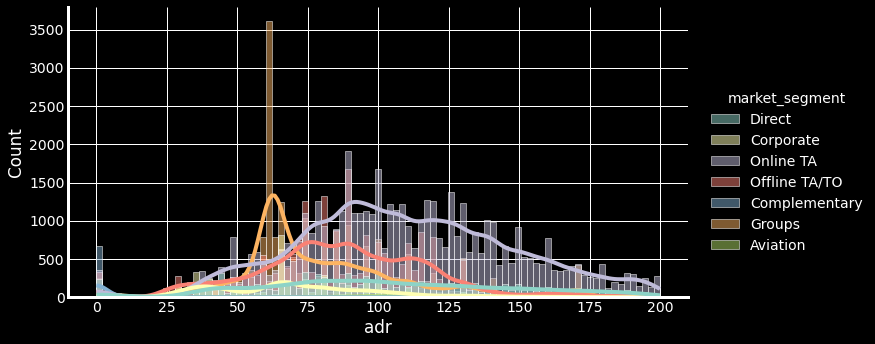

In [240]:
sns.displot(data, x="adr", hue="market_segment", kde=True, aspect = 2)

Observamos que la variable $ adr $ no sigue la distribución normal, tal como concluimos en el análisis anterior.

Por otro lado, construimos un gráfico donde podemos ver cómo varía el precio medio de la noche en cada tipo de hotel a lo largo del año:

<AxesSubplot:xlabel='arrival_date_month'>

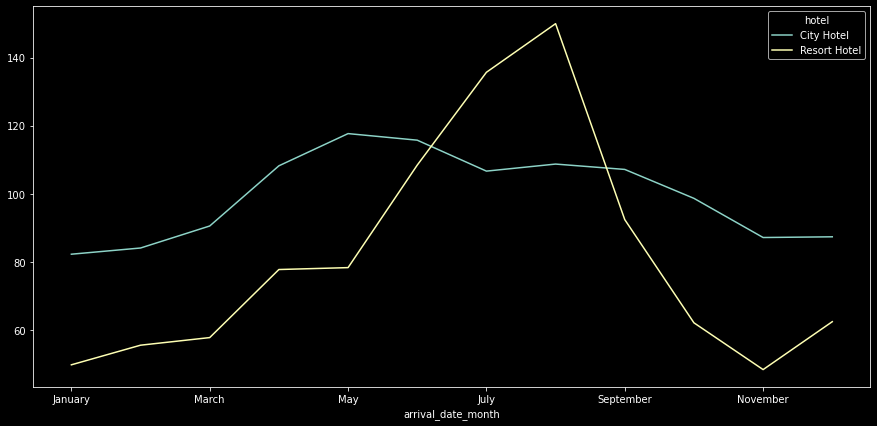

In [50]:
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 
             'November', 'December']


sorted_month_average_rate = data.groupby(['arrival_date_month','hotel']).mean()['adr'].unstack().reindex(new_order)

fig, ax = plt.subplots(figsize=(15,7))
sorted_month_average_rate.plot(ax=ax)

### Modelo de regresión lineal

Recordemos que los algoritmos de aprendizaje automático supervisados aprenden por sí mismos y, en este caso, a obtener automáticamente esa "recta" que buscamos con la tendencia de predicción. 

A partir de las características de una reserva de hotel intentaremos **predecir el precio medio de la noche**.

1. Pivotamos las variables categóricas a las columnas, convertiéndolas en indicadores:

In [52]:
datareg = data[['market_segment','total_stay','hotel','adr','reserved_room_type','arrival_date_month']]
datareg = pd.get_dummies(datareg, columns = ['market_segment', 'hotel','reserved_room_type','arrival_date_month'])
datareg.head()

,total_stay,adr,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,hotel_City Hotel,...,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September
0,3,0.0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,3,0.0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,75.0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,75.0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,2,98.0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


2. Dividir los datos en conjuntos de entrenamiento/prueba

In [54]:
X = datareg.loc[:, datareg.columns != 'adr']
y = datareg['adr']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

3. Ajustamos el modelo de regresión lineal y listamos los coeficientes:

In [55]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
 
print('Coefficients: ', reg.coef_)

Coefficients:  [ 1.15984716e-01 -2.17112487e+12 -2.17112487e+12 -2.17112487e+12
 -2.17112487e+12 -2.17112487e+12 -2.17112487e+12 -2.17112487e+12
  3.31434065e+11  3.31434065e+11  3.71080560e+11  3.71080560e+11
  3.71080560e+11  3.71080560e+11  3.71080560e+11  3.71080560e+11
  3.71080560e+11  3.71080560e+11  3.71080560e+11  3.71080560e+11
  1.93718685e+10  1.93718685e+10  1.93718684e+10  1.93718684e+10
  1.93718684e+10  1.93718685e+10  1.93718685e+10  1.93718684e+10
  1.93718685e+10  1.93718684e+10  1.93718685e+10  1.93718685e+10]


4. Obtenemos el coeficiente de determinación:

In [56]:
print('Variance score: {}'.format(reg.score(X_test, y_test)))

Variance score: 0.449236285199891


La varianza debería de ser cercana a 1.0, por lo que este modelo, en realidad, no es muy bueno... Por lo que concluimos que los atributos incorporados al modelo no son suficientes para predecir el precio medio de una noche en el hotel.

## 4.3. Correlación

No encontramos manera de optimizar el coste medio de la noche. ¿Será que las variables dependientes no están correlacionadas al $ adr $? 

<AxesSubplot:>

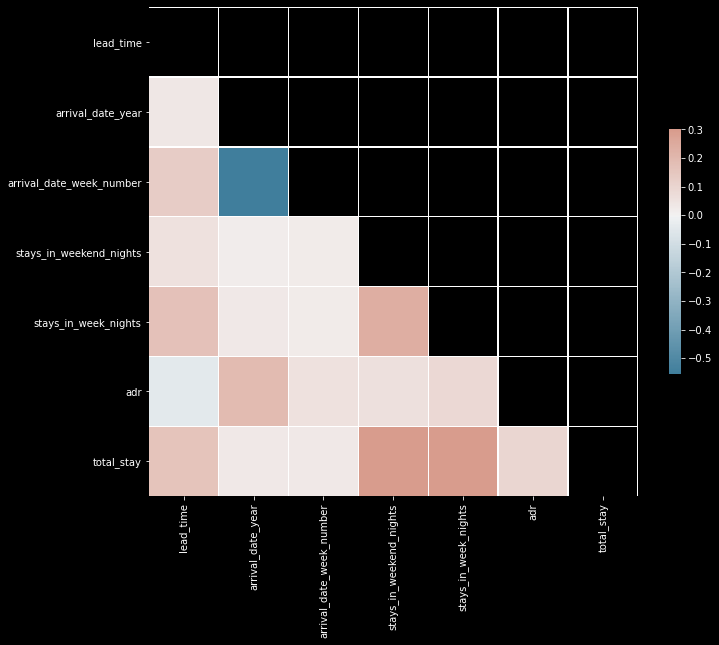

In [61]:
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Efectivamente, no existe relación alguna entre el precio medio de la noche y el resto de variables. Por esto mismo fracasaron nuestros análisis anteriores.

# 6. Conclusiones

Al principio establecimos algunas hipótesis en base a la información que nos comunicaban de primera vista las visualizaciones. No obstante, y tras un análisis más profundo aplicando **técnicas estadísticas como el contraste de hipótesis y el modelo de regresión lineal**, descubrimos que estábamos equivocados. Pero no fue hasta que construimos la matriz de correlación que identificamos la razón del fallo, y es que **las variables seleccionadas no están relacionadas entre sí**, específicamente, no están relacionadas con el $ adr $.

En conclusión, la duración de la estancia no determina el precio medio de la noche en la reserva de un hotel y no hay manera de predecir el precio tomando como punto de partida las variables seleccionads, por lo que un análisis más amplio es requerido.